In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt


# 1. 하이퍼 파라미터 지정

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 2. Mnist 데이터 다운로드

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 66390057.46it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108934976.46it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75484516.44it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18880603.34it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# 3. DataLoader 설정

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# 4. 모델 정의

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out


In [6]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(256,128,3,2,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        )

    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(64, 16, 3, 1,1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(16,1,3,2,1,1),
        nn.ReLU()
    )

  def forward(self, x):
    out = x.view(batch_size,256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out


# 5. 모델 구현 학습 및 결과 확인

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [ ]:
for i in range(num_epoch):
  for j, [image,label] in enumerate(train_loader):
    optimizer.zero_grad()
    # 노이즈 추가
    noise = init.normal_(torch.FloatTensor(batch_size, 1, 28, 28), 0, 0.1)
    image = image + noise
    image = image.to(device)


    output = encoder(image)
    output = decoder(output)

    loss = loss_func(output, image)
    loss.backward()
    print(loss)
    optimizer.step()

torch.Size([256, 28, 28])


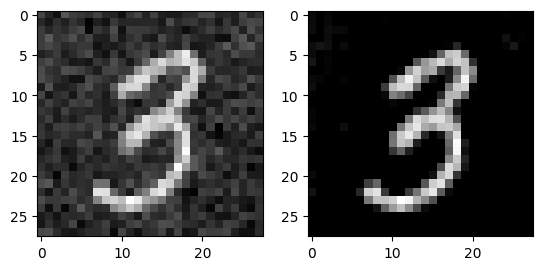

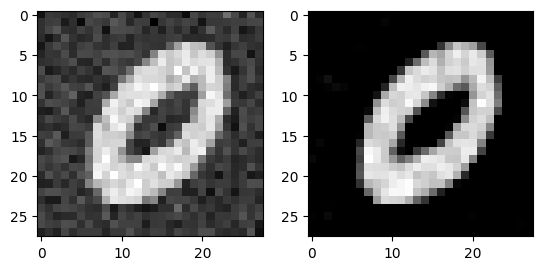

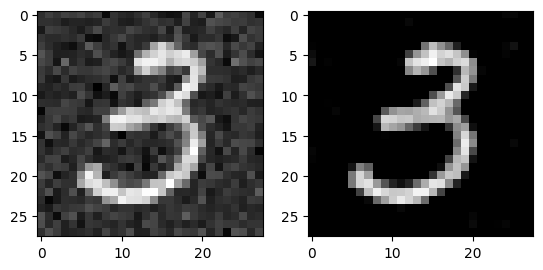

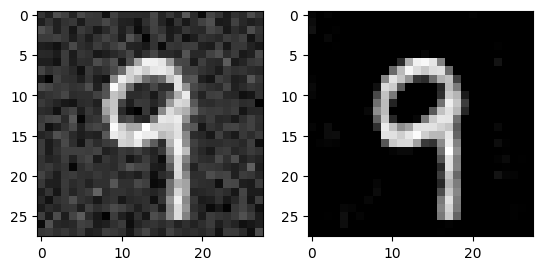

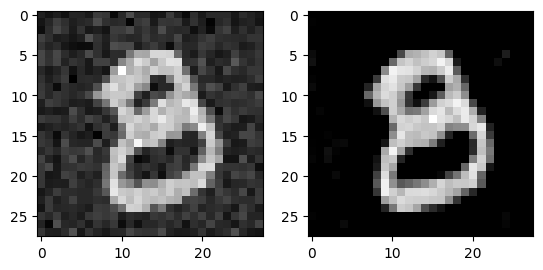

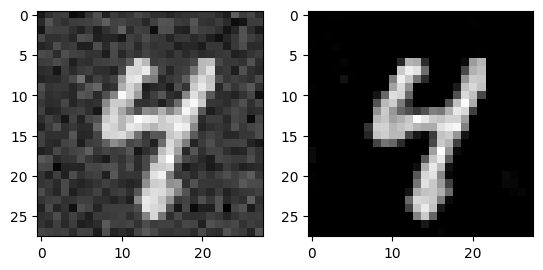

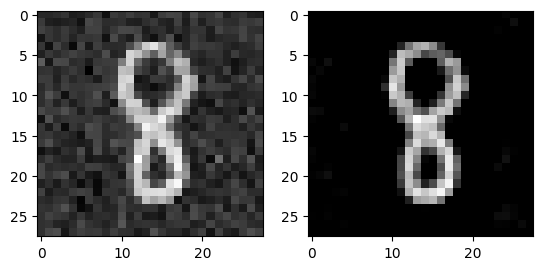

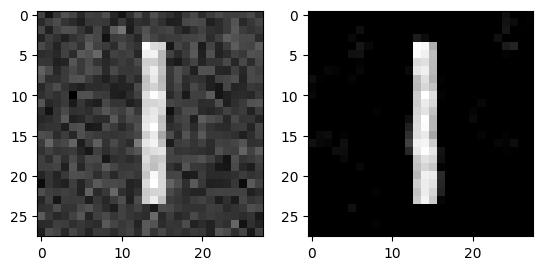

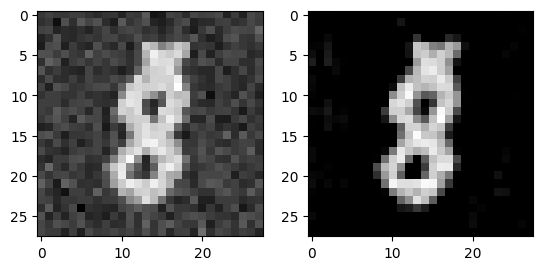

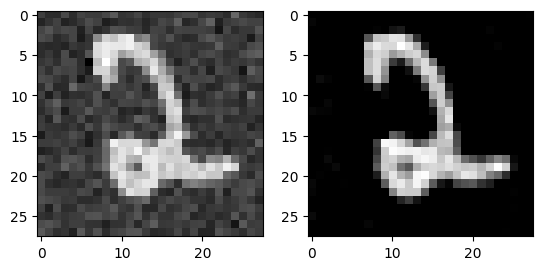

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
  plt.subplot(1,2,1)
  plt.imshow(torch.squeeze(image[i].cpu()).numpy(), cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()

# 테스트 Prediction

In [15]:
with torch.no_grad():
    for i in range(1):
        for j, [image, label] in enumerate(test_loader):
            x = image.to(device)

            optimizer.zero_grad()
            output = encoder(x)
            output = decoder(output)

            if j % 1000 == 0:
                print(loss)

tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)


torch.Size([256, 28, 28])


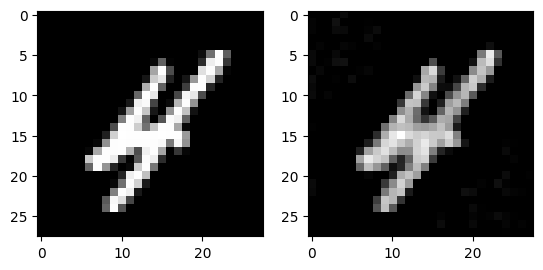

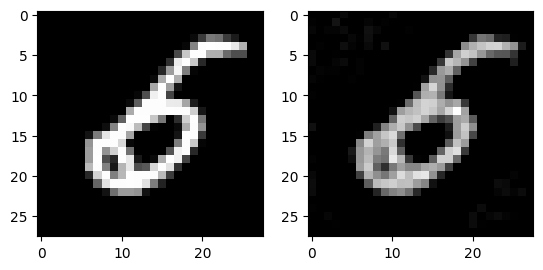

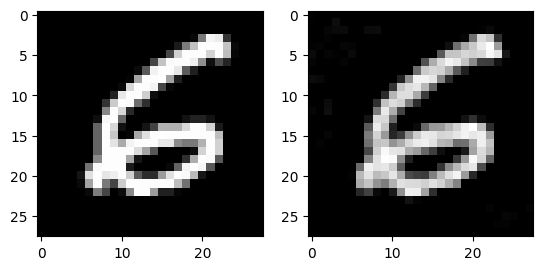

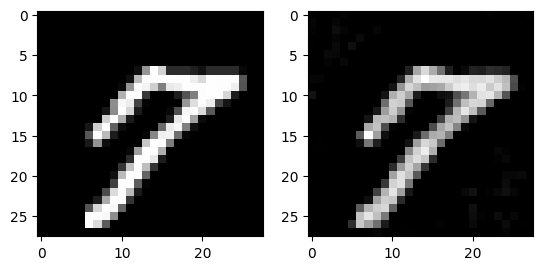

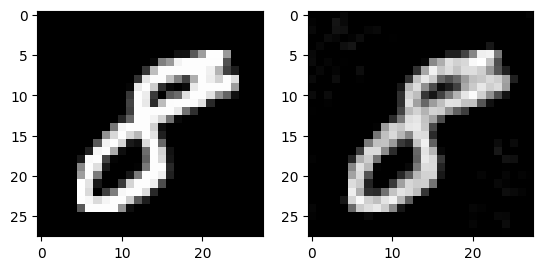

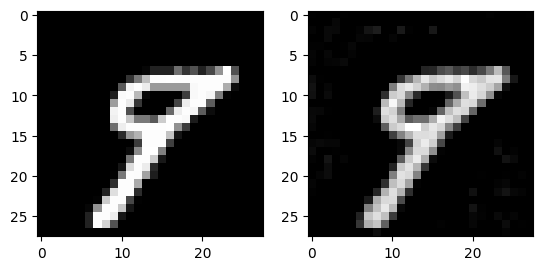

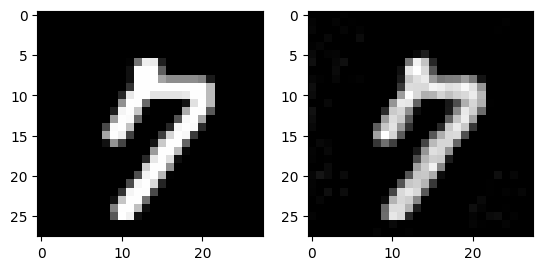

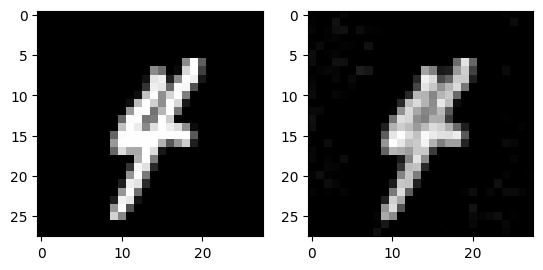

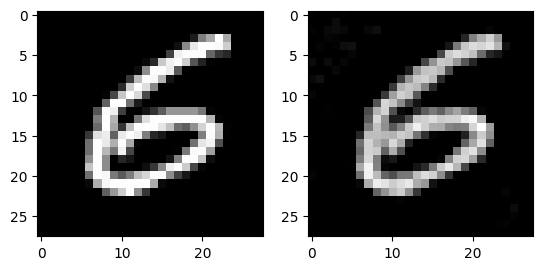

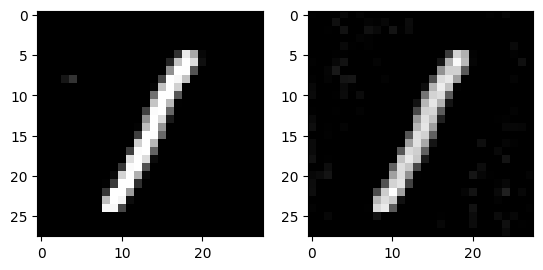

In [16]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
  plt.subplot(1,2,1)
  plt.imshow(torch.squeeze(image[i].cpu()).numpy(), cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()